**Name**: Abdurahman Mohammed <br>
**ID**: UGR/7334/13 <br>
**Stream**: AI

In [29]:
import numpy as np

**Constants**

In [30]:
K = 5
TRUE_MEANS = [2, 1, 3, 5, 0]
S = 1
T = 100000
# true probabilities of success thompson sampling
np.random.seed(42)
P = np.random.uniform(low=0.1, high=0.9, size=K).tolist()
P

[0.39963209507789,
 0.8605714451279329,
 0.685595153449124,
 0.5789267873576293,
 0.22481491235394924]

## E-Greedy

In [31]:
def EGreedy(e=0.5,k = K, true_means=TRUE_MEANS, s=S, T=T):
    Q = [0 for i in range(K)]
    action_counts = [0 for i in range(K)]
    total_reward = 0

    for i in range (T):
        rand = np.random.rand()
        arm = None
        # explore
        if (rand < e):
            arm = np.random.randint(K)
        # exploit
        else:
            arm = np.argmax(Q)
        reward = np.random.normal(TRUE_MEANS[arm], S)
        total_reward += reward
        action_counts[arm] += 1
        Q[arm] += (1/action_counts[arm]) * (reward - Q[arm])
    return Q, action_counts, total_reward
        



In [32]:
EGreedy(0.1)

([1.9966167078023345,
  0.9819341911809664,
  2.957917220657126,
  5.001786561282742,
  -0.03426592528689608],
 [2055, 2038, 2127, 91844, 1936],
 471713.4652475858)

## UCB

In [33]:
def updateUCBs(ac, q, i, c):
    # print(ac)
    epsilon = 1e-10
    return q + c * np.sqrt(np.log(i) / (ac ))
    # return q + c * np.sqrt(np.log(i) /ac)
    # return ucbs
    
def UCB(c=1,k = K, true_means=TRUE_MEANS, s=S, T=T):
    Q = np.zeros(k)
    action_counts = np.zeros(k)
    total_reward = 0
    ucbs = np.zeros(k)

    for i in range (1, T+1):
        
        arm = None
        if i <= k:
            arm = i - 1
        else:
            ucbs = updateUCBs(action_counts,Q, i, c)
            arm = np.argmax(ucbs)

        reward = np.random.normal(TRUE_MEANS[arm], S)
        total_reward += reward
        action_counts[arm] += 1
        Q[arm] += (1/action_counts[arm]) * (reward - Q[arm])
    return Q, action_counts, total_reward
        


In [34]:
UCB(10)

(array([ 1.78999422,  0.95221577,  3.0496981 ,  4.99796718, -0.11274245]),
 array([1.060e+02, 6.800e+01, 2.730e+02, 9.951e+04, 4.300e+01]),
 498429.92371670564)

## Thompson Sampling

In [35]:
def sample(alpha_beta):
    return [np.random.beta(a,b) for a,b in alpha_beta]
def update_ab(ab, reward, arm):
    if (reward == 1): ab[arm][0] += 1
    else:ab[arm][1] += 1
    return ab
def Thompson_Sampling(probs, k=K, T=T):
    # prior conjugate
    alpha_beta = [[1,1] for _ in range(k)]
    total_reward = 0
    for i in range (T):
        # sampled from postirior
        ps = sample(alpha_beta)
        # select highest
        arm = np.argmax(ps)
        reward = np.random.binomial(1, p=probs[arm])
        alpha_beta = update_ab(alpha_beta, reward, arm)
        total_reward += reward
    return total_reward, sample(alpha_beta)


## Analysis for E-Greedy, UCB and Thompson Sampling algorithms

In [36]:

# this visualisation and analysis was generated with cursor
import matplotlib.pyplot as plt
def analyze_egreedy_parameters(e_values=[0.1, 0.2, 0.3, 0.4, 0.5]):
    """
    Analyze E-Greedy algorithm with different epsilon values
    """
    results = {
        "epsilon": [],
        "total_rewards": [],
        "action_distributions": [],
        "estimated_means": [],
    }

    for e in e_values:
        Q, action_counts, total_reward = EGreedy(e=e)
        results["epsilon"].append(e)
        results["total_rewards"].append(total_reward)
        results["action_distributions"].append(action_counts)
        results["estimated_means"].append(Q)

    return results


def analyze_ucb_parameters(c_values=[0.1, 1, 2, 5, 10]):
    """
    Analyze UCB algorithm with different c values
    """
    results = {
        "c": [],
        "total_rewards": [],
        "action_distributions": [],
        "estimated_means": [],
    }

    for c in c_values:
        Q, action_counts, total_reward = UCB(c=c)
        results["c"].append(c)
        results["total_rewards"].append(total_reward)
        results["action_distributions"].append(action_counts)
        results["estimated_means"].append(Q)

    return results


def plot_parameter_analysis(results, param_name, title_prefix):
    """
    Plot analysis results for different parameter values
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Plot total rewards
    ax1.plot(results[param_name], results["total_rewards"], "bo-")
    ax1.set_xlabel(param_name)
    ax1.set_ylabel("Total Reward")
    ax1.set_title(f"{title_prefix} - Total Rewards")

    # Plot action distributions
    for i, dist in enumerate(results["action_distributions"]):
        ax2.bar(
            np.arange(K) + i * 0.15,
            dist,
            width=0.15,
            label=f"{param_name}={results[param_name][i]}",
        )
    ax2.set_xlabel("Arm")
    ax2.set_ylabel("Number of Pulls")
    ax2.set_title(f"{title_prefix} - Action Distribution")
    ax2.legend()

    # Plot estimated means vs true means
    for i, means in enumerate(results["estimated_means"]):
        ax3.plot(
            np.arange(K), means, "o-", label=f"{param_name}={results[param_name][i]}"
        )
    ax3.plot(np.arange(K), TRUE_MEANS, "k--", label="True Means")
    ax3.set_xlabel("Arm")
    ax3.set_ylabel("Mean Value")
    ax3.set_title(f"{title_prefix} - Estimated vs True Means")
    ax3.legend()

    plt.tight_layout()
    return fig


def analyze_exploration_exploitation(results, param_name):
    """
    Calculate exploration-exploitation metrics
    """
    metrics = {
        "exploration_ratio": [],
        "exploitation_ratio": [],
        "optimal_arm_pulls": [],
    }

    for dist in results["action_distributions"]:
        total_pulls = sum(dist)
        # Exploration ratio: pulls of non-optimal arms
        optimal_arm = np.argmax(TRUE_MEANS)
        non_optimal_pulls = sum(dist) - dist[optimal_arm]
        metrics["exploration_ratio"].append(non_optimal_pulls / total_pulls)
        metrics["exploitation_ratio"].append(dist[optimal_arm] / total_pulls)
        metrics["optimal_arm_pulls"].append(dist[optimal_arm])

    return metrics


def run_complete_analysis():
    """
    Run complete analysis of both algorithms
    """
    # Analyze E-Greedy
    egreedy_results = analyze_egreedy_parameters()
    egreedy_metrics = analyze_exploration_exploitation(egreedy_results, "epsilon")

    # Analyze UCB
    ucb_results = analyze_ucb_parameters()
    ucb_metrics = analyze_exploration_exploitation(ucb_results, "c")

    # Plot results
    fig1 = plot_parameter_analysis(egreedy_results, "epsilon", "E-Greedy")
    fig2 = plot_parameter_analysis(ucb_results, "c", "UCB")

    # Print metrics
    print("\nE-Greedy Analysis:")
    for i, e in enumerate(egreedy_results["epsilon"]):
        print(f"\nEpsilon = {e}:")
        print(f"Exploration Ratio: {egreedy_metrics['exploration_ratio'][i]:.3f}")
        print(f"Exploitation Ratio: {egreedy_metrics['exploitation_ratio'][i]:.3f}")
        print(f"Optimal Arm Pulls: {egreedy_metrics['optimal_arm_pulls'][i]}")

    print("\nUCB Analysis:")
    for i, c in enumerate(ucb_results["c"]):
        print(f"\nC = {c}:")
        print(f"Exploration Ratio: {ucb_metrics['exploration_ratio'][i]:.3f}")
        print(f"Exploitation Ratio: {ucb_metrics['exploitation_ratio'][i]:.3f}")
        print(f"Optimal Arm Pulls: {ucb_metrics['optimal_arm_pulls'][i]}")

    return fig1, fig2



E-Greedy Analysis:

Epsilon = 0.1:
Exploration Ratio: 0.081
Exploitation Ratio: 0.919
Optimal Arm Pulls: 91935

Epsilon = 0.2:
Exploration Ratio: 0.159
Exploitation Ratio: 0.841
Optimal Arm Pulls: 84125

Epsilon = 0.3:
Exploration Ratio: 0.239
Exploitation Ratio: 0.761
Optimal Arm Pulls: 76107

Epsilon = 0.4:
Exploration Ratio: 0.319
Exploitation Ratio: 0.681
Optimal Arm Pulls: 68098

Epsilon = 0.5:
Exploration Ratio: 0.400
Exploitation Ratio: 0.600
Optimal Arm Pulls: 59971

UCB Analysis:

C = 0.1:
Exploration Ratio: 0.000
Exploitation Ratio: 1.000
Optimal Arm Pulls: 99996.0

C = 1:
Exploration Ratio: 0.000
Exploitation Ratio: 1.000
Optimal Arm Pulls: 99993.0

C = 2:
Exploration Ratio: 0.000
Exploitation Ratio: 1.000
Optimal Arm Pulls: 99984.0

C = 5:
Exploration Ratio: 0.001
Exploitation Ratio: 0.999
Optimal Arm Pulls: 99860.0

C = 10:
Exploration Ratio: 0.005
Exploitation Ratio: 0.995
Optimal Arm Pulls: 99496.0


(<Figure size 1500x500 with 3 Axes>, <Figure size 1500x500 with 3 Axes>)

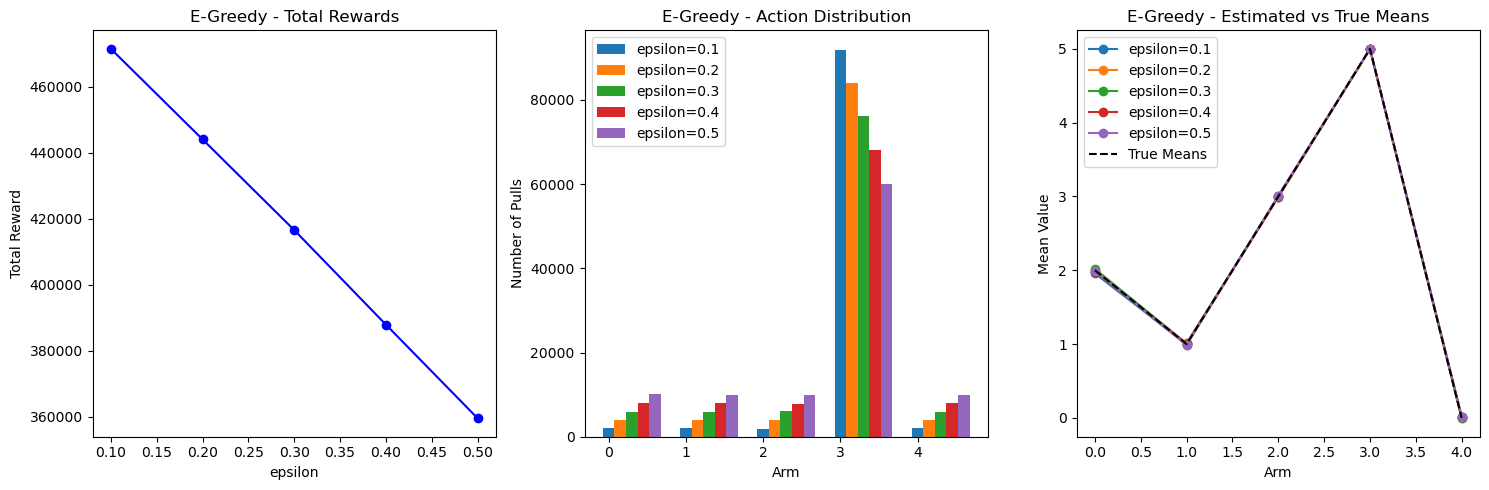

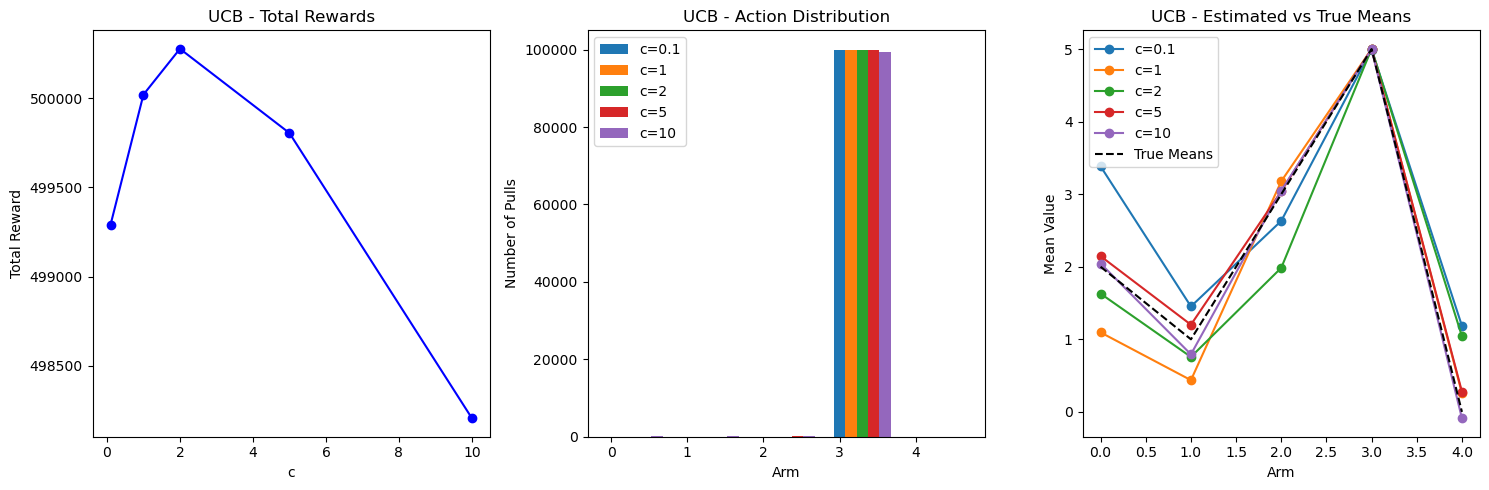

In [37]:
run_complete_analysis()


Thompson Sampling Analysis:
Average Total Reward: 86067.20
Standard Deviation of Total Reward: 127.61

Estimated Probabilities (mean ± std):
Arm 0: 0.443 ± 0.177 (True: 0.400)
Arm 1: 0.862 ± 0.002 (True: 0.861)
Arm 2: 0.635 ± 0.054 (True: 0.686)
Arm 3: 0.521 ± 0.079 (True: 0.579)
Arm 4: 0.212 ± 0.110 (True: 0.225)


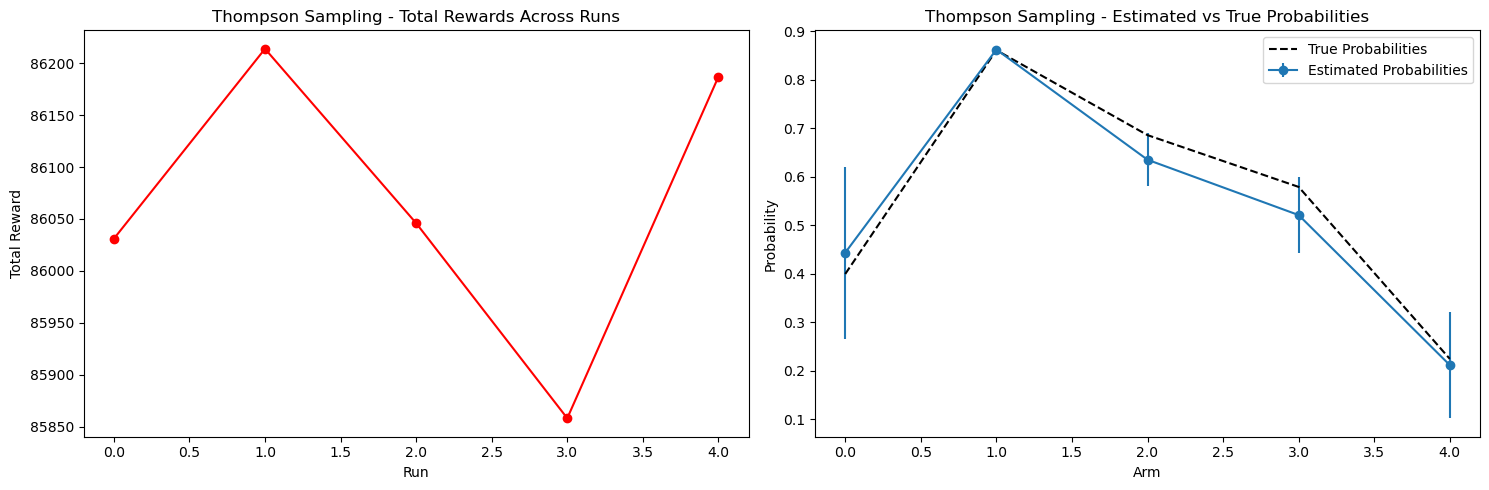

In [38]:
def analyze_thompson_sampling(n_runs=5, k=K, T=T):
    """
    Analyze Thompson Sampling algorithm with multiple runs
    """
    results = {
        "run": [],
        "total_rewards": [],
        "estimated_probs": [],
        "true_probs": P
    }
    
    for run in range(n_runs):
        np.random.seed(run)  # Different seed for each run
        total_reward, estimated_probs = Thompson_Sampling(P, k=k, T=T)
        results["run"].append(run)
        results["total_rewards"].append(total_reward)
        results["estimated_probs"].append(estimated_probs)
    
    return results
def plot_thompson_analysis(results):
    """
    Plot analysis results for Thompson Sampling
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot total rewards across runs
    ax1.plot(results["run"], results["total_rewards"], "ro-")
    ax1.set_xlabel("Run")
    ax1.set_ylabel("Total Reward")
    ax1.set_title("Thompson Sampling - Total Rewards Across Runs")
    
    # Plot estimated probabilities vs true probabilities
    mean_estimated_probs = np.mean(results["estimated_probs"], axis=0)
    std_estimated_probs = np.std(results["estimated_probs"], axis=0)
    
    ax2.errorbar(np.arange(K), mean_estimated_probs, yerr=std_estimated_probs, 
                fmt='o-', label='Estimated Probabilities')
    ax2.plot(np.arange(K), P, 'k--', label='True Probabilities')
    ax2.set_xlabel("Arm")
    ax2.set_ylabel("Probability")
    ax2.set_title("Thompson Sampling - Estimated vs True Probabilities")
    ax2.legend()
    
    plt.tight_layout()
    return fig
# Run Thompson Sampling analysis
thompson_results = analyze_thompson_sampling()
fig = plot_thompson_analysis(thompson_results)

# Print Thompson Sampling metrics
print("\nThompson Sampling Analysis:")
print(f"Average Total Reward: {np.mean(thompson_results['total_rewards']):.2f}")
print(f"Standard Deviation of Total Reward: {np.std(thompson_results['total_rewards']):.2f}")
print("\nEstimated Probabilities (mean ± std):")
mean_probs = np.mean(thompson_results['estimated_probs'], axis=0)
std_probs = np.std(thompson_results['estimated_probs'], axis=0)
for i in range(K):
    print(f"Arm {i}: {mean_probs[i]:.3f} ± {std_probs[i]:.3f} (True: {P[i]:.3f})")